In [1]:
import lightkurve as lk


import glob, os
from os import listdir
from os.path import isfile, join
import fnmatch

#Needed for making plots
import matplotlib.pyplot as plt
from matplotlib import pylab
from pylab import *
import matplotlib.gridspec as gridspec

#Needed for handling lists, arrays, strings, importing data and general math
import numpy as np
# import pandas as pd #optional (may be used in future)

#Needed for r
import astropy
from astropy.stats import BoxLeastSquares # <--- Super Important! We use this to search for periodic events in our data.
# print(astropy.__version__)


from transitleastsquares import catalog_info
from transitleastsquares import period_grid

In [2]:

def ChauventsCriteron(x, y, z, mean=None, stdv=None):
    from scipy.special import erfc
    if mean is None:
        mean = y.mean()           # Mean of incoming array y
    if stdv is None:
        stdv = y.std()            # Its standard deviation
    N = len(y)                   # Lenght of incoming arrays
    criterion = 1.0/(2*N)        # Chauvenet's criterion
    d = abs(y-mean)/stdv         # Distance of a value to mean in stdv's
    d /= 2.0**0.5                # The left and right tail threshold values
    prob = erfc(d)               # Area normal dist.    
    filter = prob >= criterion   # The 'accept' filter array with booleans
    
    xf = x[filter]; yf = y[filter]; zf=z[filter]

    return xf,yf,zf
# For some light curves, where there are flare events, we may need to 
# turn this off. (Will add in future versions)

In [3]:
#path where data is stored
SectorNum = int(input()) #<--- will ask you for Sector number: enter 1, 2, 3, etc
#^^^ A new entry field underthis cell will open and will not proceed without an input number.
# Since we are checking out Sector 1, enter 1.

print("TESS Sector",'{:02d}'.format(SectorNum)) 
# ^^^ This adds a 0 in front of numbers 1-9. For numbers 10 and greater, this will not put a 0 in front.

path = '/Users/felizd/Desktop/TESS/Sector'+str('{:02d}'.format(SectorNum))+'/curves/clean'

#path where figures will be saved
figpath = '/Users/felizd/Desktop/TESS/Sector'+str('{:02d}'.format(SectorNum))+'/plots/' 

#path where we will save our light curves later
savepath = '/Users/felizd/Desktop/TESS/Sector'+str('{:02d}'.format(SectorNum))+'/processed/' 

#This portion of code is designed to recursively search through a directory 
#for all files in the path that end with .lc in their filename
data = [os.path.join(dirpath, f) # an array of path names to be looped over
    for dirpath, dirnames, files in os.walk(path) #recursively searches through directory
    for f in fnmatch.filter(files, '*.lc')] #finds every file (*) that ends with .lc

data.sort(key=lambda x: int(os.path.basename(x).split('_')[0])) #sorts them in alphanumeric order based on TIC ID (smallest first)

print ("number of files: ",len(data)) #number of files)

1
TESS Sector 01
number of files:  917


In [4]:
print(data[0]); print(" ")
print(data[1]); print(" ")
print(data[2]); print(" ")
print(data[3]); print(" ")
print(data[4]); print(" ")
print(data[5]); print(" ")
print(data[6]); print(" ")

/Users/felizd/Desktop/TESS/Sector01/curves/clean/24749559_sector01_3_4.lc
 
/Users/felizd/Desktop/TESS/Sector01/curves/clean/24750692_sector01_3_4.lc
 
/Users/felizd/Desktop/TESS/Sector01/curves/clean/25115881_sector01_4_1.lc
 
/Users/felizd/Desktop/TESS/Sector01/curves/clean/25132720_sector01_4_1.lc
 
/Users/felizd/Desktop/TESS/Sector01/curves/clean/25167696_sector01_1_3.lc
 
/Users/felizd/Desktop/TESS/Sector01/curves/clean/25200252_sector01_1_3.lc
 
/Users/felizd/Desktop/TESS/Sector01/curves/clean/25283002_sector01_1_3.lc
 


0
1
2
3
4
5
filenumber 5
TIC 25200252
best period:  1.2056245835603814
best T0:  0.30643908358045646


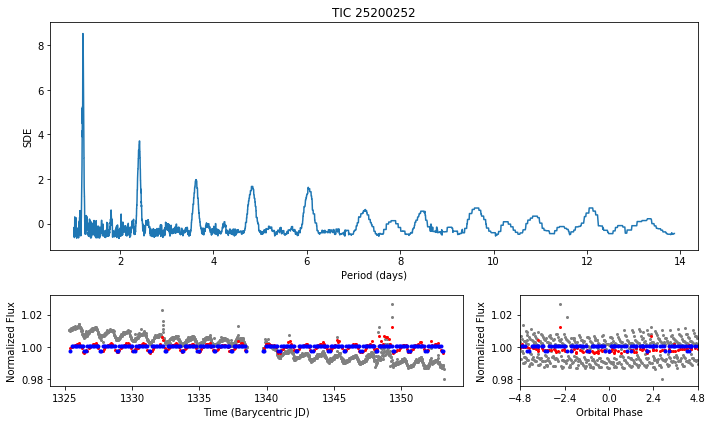


6
7
8
9
10
11


In [14]:
spacing = 0.02

# for ii in range(len(data)): #creating a for loop to show light curve figures for all files
for ii in range(12): #creating a for loop to show light curve figures for all files    
    print(ii)
    time     = np.transpose(np.loadtxt(data[ii]))[0] #first  (zero indexing in python) column 
    mag      = np.transpose(np.loadtxt(data[ii]))[1] #second (zero indexing in python) column 
    magerror = np.transpose(np.loadtxt(data[ii]))[2] #third (zero indexing in python) column 
    
    mask = np.where(np.isnan(mag)==False)[0] #creating array of only real numbers by setting np.isnan(mag)==False. 
    time = time[mask]                        #Sometimes there are holes in data filled with NaNs
    mag = mag[mask]
    magerror = magerror[mask]
    
    flux = 10.0**(mag/-2.5)/np.mean(10.0**(mag/-2.5))
    fluxerror = flux*(10.0**(magerror/2.5)-1.0)
    
    #removing outliers with Chauvenet's criterion
    t2,f2,fe2 = ChauventsCriteron(time,flux,fluxerror)
    
    lc = lk.LightCurve(t2,f2,fe2)
    
    bin_size = 5
    cad = time[1]-time[0]
    #now let's define a window size to smooth our data with:

    window_size = int(5.0/cad) #number of data points in 5 hours
    if (window_size % 2) == 0: #must be odd. If not, there will be an error
        window_size = window_size+1
        
    detrended_lc = lc.flatten(window_length=window_size).bin(binsize=bin_size)
    
    ID = (os.path.basename(data[ii]).split)('_')[0]


    Sector = "S"+(os.path.basename(data[ii]).split)('_')[1][1:] #by default, this has lower case "s"
    #^^^ so I added a capital "S" and remove the first element ("s") of this string
    # with this index slice [1:]. This isn't really imporant, just being tidy.

    Camera = (os.path.basename(data[ii]).split)('_')[2] 
    CCD = (os.path.basename(data[ii]).split)('_')[3][-4]
    
    
    #doing BLS search:
    
    qld, R_star, R_star_min, R_star_max, M_star, M_star_min, M_star_max = catalog_info(TIC_ID=int(ID))   
    #^^^ grabbing stellar information from MAST catalogs
    
    if np.isfinite(R_star)==True and np.isfinite(M_star)==True: #checks to see if stellar information is unknown in MAST catalogs
        minP=1.01
        maxP= (max(detrended_lc.time)-min(detrended_lc.time)) #length of our light curve
        minDur = 1.0/24.0
        maxDur = 5.0/24.0
        
        #creating list of orbital periods to model with
        periods = period_grid(R_star=R_star, M_star=M_star, time_span=maxP, period_min=minP, period_max=maxP)#,oversampling_factor=10)

        durations = np.linspace(minDur,maxDur,25)
    

        bls = BoxLeastSquares(detrended_lc.time, detrended_lc.flux, detrended_lc.flux_err)
        bls_power = bls.power(periods, durations)
        
        bls_SDE = (bls_power.power - np.mean(bls_power.power))/np.std(bls_power.power)
        
        SDE_threshold=6.5 
        
        #phase folding with best BLS model
        index = np.argmax(bls_power.power); 
        best_period = bls_power.period[index]; 
        best_t0 = bls_power.transit_time[index];
        BLS_depths=bls_power.depth[index]
        dur = minDur #0.5

        #creating the best fit box model to our data
        bls_model=bls.model(detrended_lc.time,bls_power.period[index], bls_power.duration[index], bls_power.transit_time[index])
        
        detrendedphasefoldedlc = [detrended_lc.fold(period=best_period,t0=best_t0).phase,detrended_lc.fold(period=best_period,t0=best_t0).flux, detrended_lc.fold(period=best_period,t0=best_t0).flux_err]
        phasefoldedlc = [lc.fold(period=best_period,t0=best_t0).phase,lc.fold(period=best_period,t0=best_t0).flux, lc.fold(period=best_period,t0=best_t0).flux_err]


        if len(np.where(bls_SDE>SDE_threshold)[0])>0:
            
            print("filenumber",ii)
            print("TIC", ID)
            print("best period: ", best_period)
            print("best T0: ",best_t0)

            gs1 = gridspec.GridSpec(3, 3)
            gs1.update(left=0.65, right=1.25, wspace=0.25,hspace=0.5)


            f = plt.figure(figsize=(10,6))
            ax1 = f.add_subplot(gs1[:-1, :])
            ax2 = f.add_subplot(gs1[-1, :-1])
            ax3 = f.add_subplot(gs1[-1, -1])


        #     ax1.plot(periodogram.period, periodogram.power, rasterized=True) 
            ax1.plot(bls_power.period, bls_SDE, rasterized=True) 
            plt.xticks(np.arange(0.0, 31.0, 1.0))
            ax1.set_title("TIC "+ ID)
            ax1.set_xlabel("Period (days)")
            ax1.set_xlim(np.min(bls_power.period)-0.5, np.max(bls_power.period)+0.5)
        #     ax1.set_ylabel("BLS Power SNR")
            ax1.set_ylabel("SDE")
        #     ax1.set_ylim(np.min(periodogram.power)-0.5, np.max(periodogram.power)+0.5)
            ax1.set_ylim(np.min(bls_SDE)-0.5, np.max(bls_SDE)+0.5)

            ax2.plot(detrended_lc.time,detrended_lc.flux,c='red',markersize=4,marker='.',linestyle='none',zorder=1,label='detrended: windowsize: '+str(window_size)+", binsize: "+str(bin_size)) 
            ax2.plot(time,flux,c='grey',marker='.',markersize=4,linestyle='none',zorder=0,label='undetrended')
            ax2.plot(detrended_lc.time,bls_model,'b.',label='BLS model')
        #     ax2.legend(loc='upper right')
        #     ax2.set_ylim(0.985,1.015)
            ax2.set_ylim(np.min(detrended_lc.flux)-spacing, np.max(detrended_lc.flux)+spacing)
            ax2.set_xlabel("Time (Barycentric JD)")
            ax2.set_ylabel("Normalized Flux") 

            ax3.plot(24*detrendedphasefoldedlc[0],detrendedphasefoldedlc[1],c='red',markersize=4,marker='.',linestyle='none',zorder=1,label='detrended: windowsize: '+str(window_size)+", binsize: "+str(bin_size))
            ax3.plot(24*phasefoldedlc[0],phasefoldedlc[1],c='grey',marker='.',markersize=4,linestyle='none',zorder=0,label='undetrended')
            ax3.plot(24*detrendedphasefoldedlc[0],bls_model,'b.',label='BLS model')
        #     ax3.legend(loc='upper right')
            ax3.set_xlabel("Orbital Phase")
            ax3.set_ylabel("Normalized Flux") 
        #     ax3.set_ylim(0.985,1.015)
            ax3.set_ylim(np.min(detrended_lc.flux)-spacing, np.max(detrended_lc.flux)+spacing)
            ax3.set_xticks(np.arange(np.min(24*phasefoldedlc[0]),np.max(24*phasefoldedlc[0])+0.1*24,24*0.1))
            ax3.set_xlim(-0.2*24,0.2*24)
            gs1.tight_layout(f)

            plt.savefig(figpath+"TIC_"+ID+"_"+Sector+"_Camera_"+Camera+"_CCD_"+CCD+"_BLS.png")
            plt.show()    
            print( "") #adds space between figures
    else:
        continue
        print(" ") #adds space between figures
            
        
        
    
    

In [25]:
for x in range(10):
    print (data[x])
    print(" ")

/Users/felizd/Desktop/TESS/Sector01/curves/clean/24749559_sector01_3_4.lc
 
/Users/felizd/Desktop/TESS/Sector01/curves/clean/24750692_sector01_3_4.lc
 
/Users/felizd/Desktop/TESS/Sector01/curves/clean/25115881_sector01_4_1.lc
 
/Users/felizd/Desktop/TESS/Sector01/curves/clean/25132720_sector01_4_1.lc
 
/Users/felizd/Desktop/TESS/Sector01/curves/clean/25167696_sector01_1_3.lc
 
/Users/felizd/Desktop/TESS/Sector01/curves/clean/25200252_sector01_1_3.lc
 
/Users/felizd/Desktop/TESS/Sector01/curves/clean/25283002_sector01_1_3.lc
 
/Users/felizd/Desktop/TESS/Sector01/curves/clean/25357782_sector01_1_3.lc
 
/Users/felizd/Desktop/TESS/Sector01/curves/clean/29543294_sector01_1_4.lc
 
/Users/felizd/Desktop/TESS/Sector01/curves/clean/29669751_sector01_1_4.lc
 
